In [40]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import optuna

In [5]:
df = pd.read_csv("feature_engineered.csv", parse_dates=["settlement_date"])
df = df.set_index("settlement_date")
df = df.asfreq("30min")
df = df.dropna()

In [6]:
feature_cols = [
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "lag_1",
    "lag_24",
    "lag_48",
    "lag_168",
    "rolling_24h_mean",
    "rolling_24h_std",
    "rolling_7d_mean"
]
target_col = "nd"

train = df.loc["2009":"2021"]
val = df.loc["2022":"2023"]
test = df.loc["2024"]

X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

In [11]:
lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=50,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="l2"
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Info] Start training from score 32284.655827


,boosting_type,'gbdt'
,num_leaves,50
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [13]:
y_val_pred_lgbm = lgbm.predict(X_val)
y_test_pred_lgbm = lgbm.predict(X_test)

print("Validation Data MAE:", mean_absolute_error(y_val, y_val_pred_lgbm))
print("Validation Data RMSE:", root_mean_squared_error(y_val, y_val_pred_lgbm))

print("Test Data MAE:", mean_absolute_error(y_test, y_test_pred_lgbm))
print("Test Data RMSE:", root_mean_squared_error(y_test, y_test_pred_lgbm))

Validation Data MAE: 280.7650066607234
Validation Data RMSE: 375.3506594447655
Test Data MAE: 307.0715156098752
Test Data RMSE: 412.261997305136


In [15]:
y_val_result = pd.DataFrame({
    "actual": y_val,
    "predicted": y_val_pred_lgbm
})

y_test_result = pd.DataFrame({
    "actual": y_test,
    "predicted": y_test_pred_lgbm
})

In [14]:
def figure_design():
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(axis="both",direction="in", top=True, right=True)

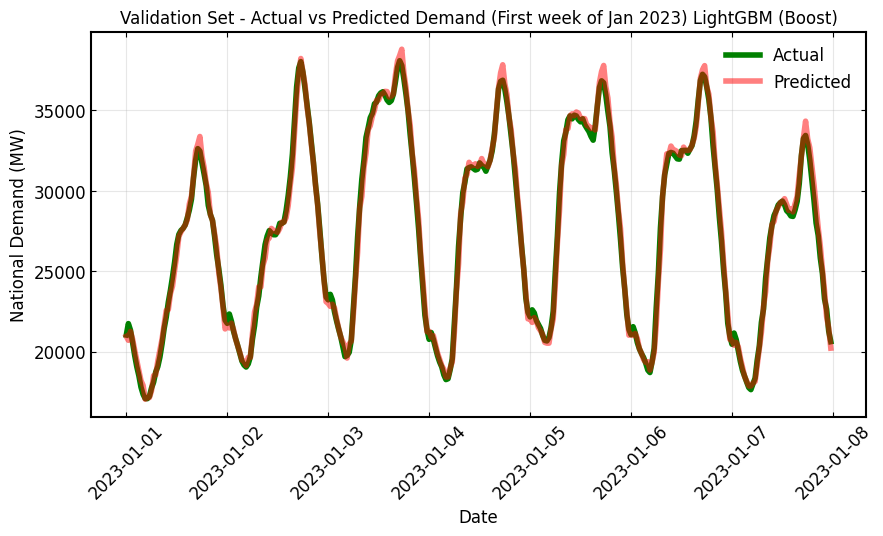

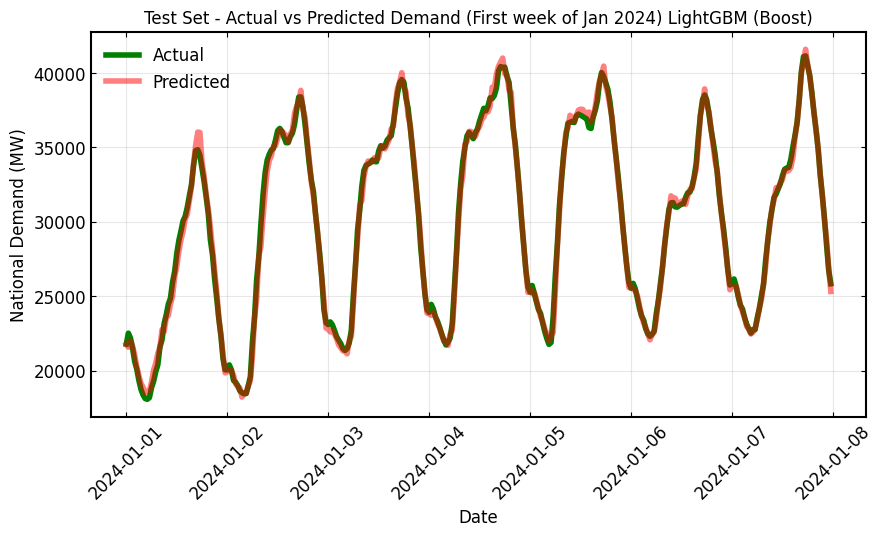

In [23]:
week_slice_val = y_val_result.loc["2023-01-01":"2023-01-07"]

plt.figure(figsize=(10, 5))
plt.plot(week_slice_val.index, week_slice_val["actual"], label="Actual", linewidth=4, color="green")
plt.plot(week_slice_val.index, week_slice_val["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Validation Set - Actual vs Predicted Demand (First week of Jan 2023) LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

week_slice_test = y_test_result.loc["2024-01-01":"2024-01-07"]

plt.figure(figsize=(10, 5))
plt.plot(week_slice_test.index, week_slice_test["actual"], label="Actual", linewidth=4, color="green")
plt.plot(week_slice_test.index, week_slice_test["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Test Set - Actual vs Predicted Demand (First week of Jan 2024) LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

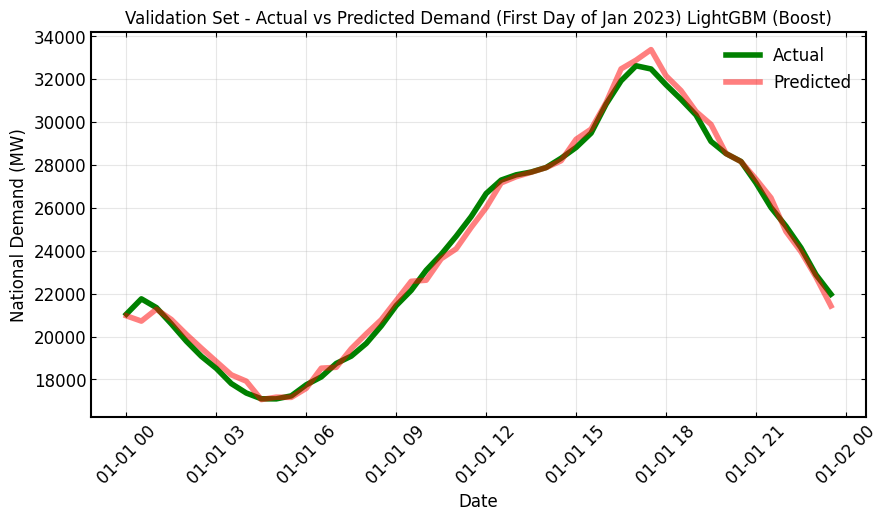

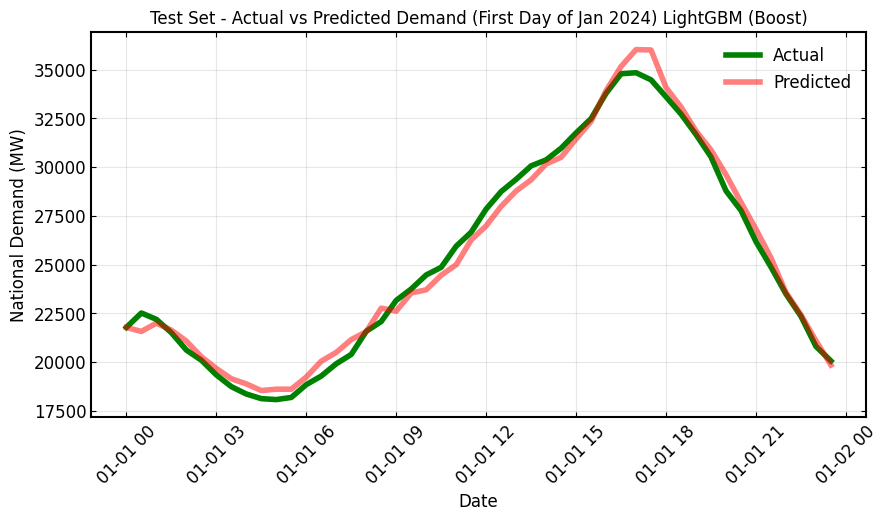

In [24]:
day_slice_val = y_val_result.loc["2023-01-01":"2023-01-01"]

plt.figure(figsize=(10, 5))
plt.plot(day_slice_val.index, day_slice_val["actual"], label="Actual", linewidth=4, color="green")
plt.plot(day_slice_val.index, day_slice_val["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Validation Set - Actual vs Predicted Demand (First Day of Jan 2023) LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

day_slice_test = y_test_result.loc["2024-01-01":"2024-01-01"]

plt.figure(figsize=(10, 5))
plt.plot(day_slice_test.index, day_slice_test["actual"], label="Actual", linewidth=4, color="green")
plt.plot(day_slice_test.index, day_slice_test["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Test Set - Actual vs Predicted Demand (First Day of Jan 2024) LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

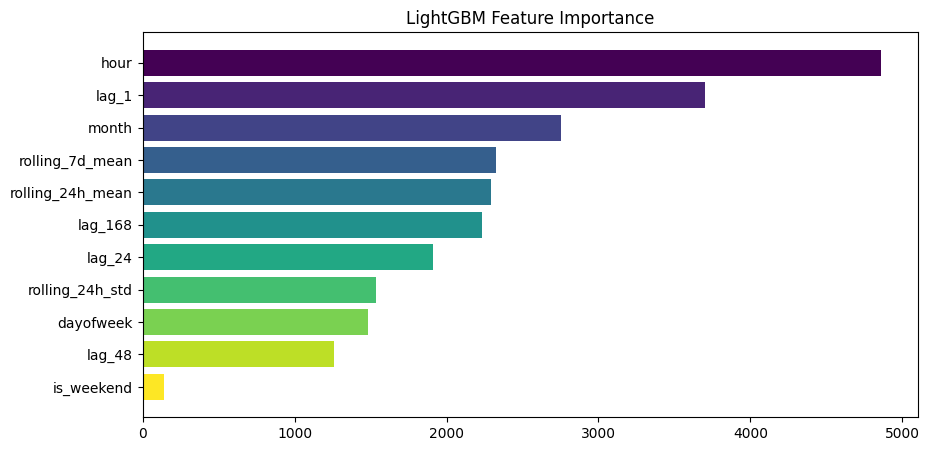

In [39]:
importance = lgbm.feature_importances_

feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importance,
}).sort_values(by="importance", ascending=False)

colors = plt.cm.viridis(np.linspace(0, 1, 11))

plt.figure(figsize=(10,5))
plt.barh(feature_importance["feature"], feature_importance["importance"], color=colors)
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [62]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
    )

    y_val_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_val_pred)
    return rmse


In [48]:
study = optuna.create_study(
    direction="minimize",
    study_name="lgbm_load_forecast",
)

study.optimize(objective, n_trials=30)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-11-19 14:59:46,160] A new study created in memory with name: lgbm_load_forecast


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-11-19 14:59:49,640] Trial 0 finished with value: 376.13051414911644 and parameters: {'n_estimators': 647, 'learning_rate': 0.06933018174734917, 'num_leaves': 198, 'max_depth': 6, 'min_child_samples': 85, 'subsample': 0.7375757900971527, 'colsample_bytree': 0.8750053105695124, 'reg_alpha': 6.968878993323614, 'reg_beta': 3.605539497619985e-08}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] Unknown parameter: reg_beta


[I 2025-11-19 15:00:02,551] Trial 1 finished with value: 397.8663553383057 and parameters: {'n_estimators': 923, 'learning_rate': 0.010569590369369782, 'num_leaves': 193, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.5826490244035993, 'colsample_bytree': 0.7326429788683624, 'reg_alpha': 1.7501667356828716e-08, 'reg_beta': 4.036277075064309e-08}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] Unknown parameter: reg_beta


[I 2025-11-19 15:00:19,579] Trial 2 finished with value: 398.1506601193886 and parameters: {'n_estimators': 1032, 'learning_rate': 0.02517948944009443, 'num_leaves': 176, 'max_depth': 16, 'min_child_samples': 46, 'subsample': 0.753394654570392, 'colsample_bytree': 0.5239799611898344, 'reg_alpha': 0.02106183104330559, 'reg_beta': 0.7294591838944908}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] Unknown parameter: reg_beta


[I 2025-11-19 15:00:24,812] Trial 3 finished with value: 395.96070399612677 and parameters: {'n_estimators': 1009, 'learning_rate': 0.042778941314540075, 'num_leaves': 24, 'max_depth': 16, 'min_child_samples': 53, 'subsample': 0.9230857186073202, 'colsample_bytree': 0.5805432683327509, 'reg_alpha': 0.5378560315337386, 'reg_beta': 1.097672567020276e-08}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:00:26,671] Trial 4 finished with value: 486.1451502565222 and parameters: {'n_estimators': 307, 'learning_rate': 0.022903962071702585, 'num_leaves': 26, 'max_depth': 7, 'min_child_samples': 177, 'subsample': 0.9320712029036002, 'colsample_bytree': 0.7178951312063349, 'reg_alpha': 0.00018114022173280108, 'reg_beta': 0.021247834665399187}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:00:31,416] Trial 5 finished with value: 498.022111639803 and parameters: {'n_estimators': 396, 'learning_rate': 0.018743246295548, 'num_leaves': 98, 'max_depth': 16, 'min_child_samples': 196, 'subsample': 0.6544254820603517, 'colsample_bytree': 0.5708906259199757, 'reg_alpha': 3.342591108142558e-08, 'reg_beta': 1.8568263652764884e-08}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-11-19 15:00:36,593] Trial 6 finished with value: 429.3347865590964 and parameters: {'n_estimators': 1027, 'learning_rate': 0.024471480673996987, 'num_leaves': 104, 'max_depth': 5, 'min_child_samples': 87, 'subsample': 0.9518973631416455, 'colsample_bytree': 0.550583345169231, 'reg_alpha': 0.26566430014287473, 'reg_beta': 1.2742183392996582e-08}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-11-19 15:00:39,462] Trial 7 finished with value: 598.8345500704548 and parameters: {'n_estimators': 360, 'learning_rate': 0.01280280469101635, 'num_leaves': 172, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.6773047510393264, 'colsample_bytree': 0.6072181077154235, 'reg_alpha': 0.21115630709354224, 'reg_beta': 5.75191194641629e-07}. Best is trial 0 with value: 376.13051414911644.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:00:42,245] Trial 8 finished with value: 370.5735568931861 and parameters: {'n_estimators': 502, 'learning_rate': 0.12871874447218387, 'num_leaves': 38, 'max_depth': 16, 'min_child_samples': 176, 'subsample': 0.8944986341130524, 'colsample_bytree': 0.8000484342438438, 'reg_alpha': 0.000958268405647493, 'reg_beta': 2.207753490090374}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-11-19 15:00:55,420] Trial 9 finished with value: 392.7584335961932 and parameters: {'n_estimators': 1118, 'learning_rate': 0.14338066326952276, 'num_leaves': 193, 'max_depth': 14, 'min_child_samples': 47, 'subsample': 0.5377859926088904, 'colsample_bytree': 0.9916374489635402, 'reg_alpha': 1.1062824843232062e-08, 'reg_beta': 5.701855647539596e-06}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-11-19 15:00:59,353] Trial 10 finished with value: 376.7050573388472 and parameters: {'n_estimators': 616, 'learning_rate': 0.16124089919755738, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 150, 'subsample': 0.8355284320937542, 'colsample_bytree': 0.8502791729508581, 'reg_alpha': 5.471127267616001e-05, 'reg_beta': 6.80102283280374}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-11-19 15:01:04,294] Trial 11 finished with value: 377.1395241615253 and parameters: {'n_estimators': 625, 'learning_rate': 0.08484850806213115, 'num_leaves': 145, 'max_depth': 9, 'min_child_samples': 120, 'subsample': 0.8147380098154837, 'colsample_bytree': 0.8766645069558119, 'reg_alpha': 7.449388806742081, 'reg_beta': 0.000337812589992727}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:01:06,574] Trial 12 finished with value: 428.77226899633223 and parameters: {'n_estimators': 792, 'learning_rate': 0.07957506305639597, 'num_leaves': 136, 'max_depth': 3, 'min_child_samples': 106, 'subsample': 0.8538131915460958, 'colsample_bytree': 0.8510679290672604, 'reg_alpha': 3.3919428615752036e-06, 'reg_beta': 0.0007624436508505083}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-11-19 15:01:09,439] Trial 13 finished with value: 372.76594566493435 and parameters: {'n_estimators': 527, 'learning_rate': 0.08408998767870947, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 147, 'subsample': 0.7480010164958009, 'colsample_bytree': 0.9303055314291444, 'reg_alpha': 0.004528096792537633, 'reg_beta': 1.1959989644892813e-05}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:01:12,754] Trial 14 finished with value: 371.3373056665912 and parameters: {'n_estimators': 480, 'learning_rate': 0.1146573500227871, 'num_leaves': 63, 'max_depth': 11, 'min_child_samples': 152, 'subsample': 0.9992453103912772, 'colsample_bytree': 0.9615269545084831, 'reg_alpha': 0.003020341959368243, 'reg_beta': 1.3623117642828237e-05}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:01:16,191] Trial 15 finished with value: 379.2220608361656 and parameters: {'n_estimators': 471, 'learning_rate': 0.19896414471541002, 'num_leaves': 73, 'max_depth': 13, 'min_child_samples': 161, 'subsample': 0.9929375611763344, 'colsample_bytree': 0.6650507729733642, 'reg_alpha': 0.00264229945535472, 'reg_beta': 0.01566028655211125}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-11-19 15:01:18,173] Trial 16 finished with value: 377.47121373228646 and parameters: {'n_estimators': 215, 'learning_rate': 0.1171302785660436, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 197, 'subsample': 0.8851003160815749, 'colsample_bytree': 0.8046066138813257, 'reg_alpha': 8.268449166846054e-06, 'reg_beta': 1.6433837049945558e-05}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] Unknown parameter: reg_beta


[I 2025-11-19 15:01:22,363] Trial 17 finished with value: 372.3134350821208 and parameters: {'n_estimators': 773, 'learning_rate': 0.04701983748230868, 'num_leaves': 45, 'max_depth': 13, 'min_child_samples': 130, 'subsample': 0.9963346598436487, 'colsample_bytree': 0.9842750206383863, 'reg_alpha': 0.0012034721929869059, 'reg_beta': 0.009103824816476466}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] Unknown parameter: reg_beta


[I 2025-11-19 15:01:25,361] Trial 18 finished with value: 370.9140092074248 and parameters: {'n_estimators': 504, 'learning_rate': 0.11147578864182578, 'num_leaves': 50, 'max_depth': 14, 'min_child_samples': 172, 'subsample': 0.8929570034466908, 'colsample_bytree': 0.7930857006762315, 'reg_alpha': 1.924333519950588e-06, 'reg_beta': 9.842116945825051}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:01:32,588] Trial 19 finished with value: 370.70243172279027 and parameters: {'n_estimators': 779, 'learning_rate': 0.045954972018036486, 'num_leaves': 94, 'max_depth': 14, 'min_child_samples': 183, 'subsample': 0.7979505436792502, 'colsample_bytree': 0.7880520366371293, 'reg_alpha': 3.9089597568329306e-07, 'reg_beta': 7.823741684185168}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:01:41,660] Trial 20 finished with value: 377.89059391405317 and parameters: {'n_estimators': 846, 'learning_rate': 0.04244732029965354, 'num_leaves': 122, 'max_depth': 15, 'min_child_samples': 179, 'subsample': 0.795179492761622, 'colsample_bytree': 0.6770718476531519, 'reg_alpha': 2.540542861833082e-07, 'reg_beta': 0.374671248156164}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:01:44,923] Trial 21 finished with value: 372.29107926362923 and parameters: {'n_estimators': 541, 'learning_rate': 0.061689974706552554, 'num_leaves': 45, 'max_depth': 14, 'min_child_samples': 175, 'subsample': 0.8822435070802768, 'colsample_bytree': 0.7720484817896626, 'reg_alpha': 6.701074472517436e-07, 'reg_beta': 6.527811960171996}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-11-19 15:01:50,549] Trial 22 finished with value: 372.45065620575326 and parameters: {'n_estimators': 712, 'learning_rate': 0.10780201062113498, 'num_leaves': 90, 'max_depth': 14, 'min_child_samples': 168, 'subsample': 0.8738984297140465, 'colsample_bytree': 0.7886771930763393, 'reg_alpha': 2.3356235672153354e-05, 'reg_beta': 0.4276753747995026}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:01:54,772] Trial 23 finished with value: 384.62883842263585 and parameters: {'n_estimators': 417, 'learning_rate': 0.03395020094306279, 'num_leaves': 84, 'max_depth': 15, 'min_child_samples': 199, 'subsample': 0.7894882291734051, 'colsample_bytree': 0.8083191670740849, 'reg_alpha': 7.71350860403209e-07, 'reg_beta': 1.1308989155134679}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:01:57,715] Trial 24 finished with value: 383.7878000442798 and parameters: {'n_estimators': 579, 'learning_rate': 0.0569092235641831, 'num_leaves': 32, 'max_depth': 13, 'min_child_samples': 135, 'subsample': 0.9282434047011094, 'colsample_bytree': 0.6809501853259259, 'reg_alpha': 1.0882010546010965e-07, 'reg_beta': 0.11468578221316093}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-11-19 15:02:03,540] Trial 25 finished with value: 382.91360771257774 and parameters: {'n_estimators': 718, 'learning_rate': 0.18504879328576418, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 184, 'subsample': 0.7121970547596894, 'colsample_bytree': 0.7523406326792644, 'reg_alpha': 0.00019566368224874838, 'reg_beta': 9.501553356152273}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-11-19 15:02:05,503] Trial 26 finished with value: 376.60034054446874 and parameters: {'n_estimators': 287, 'learning_rate': 0.12479872175936754, 'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 162, 'subsample': 0.8328201677867062, 'colsample_bytree': 0.9273335048653781, 'reg_alpha': 3.1389884582983265e-06, 'reg_beta': 0.06383386009433752}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-11-19 15:02:12,129] Trial 27 finished with value: 379.45329175838447 and parameters: {'n_estimators': 871, 'learning_rate': 0.16331015222997058, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 141, 'subsample': 0.7764794680439101, 'colsample_bytree': 0.8278748471473187, 'reg_alpha': 3.6599259338042536e-05, 'reg_beta': 2.5087183131918667}. Best is trial 8 with value: 370.5735568931861.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:02:15,233] Trial 28 finished with value: 368.38873071517924 and parameters: {'n_estimators': 680, 'learning_rate': 0.0979327686225392, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 189, 'subsample': 0.8991106641563034, 'colsample_bytree': 0.7258781974186034, 'reg_alpha': 1.0802938176008803e-07, 'reg_beta': 0.001608840431272534}. Best is trial 28 with value: 368.38873071517924.


[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 220726, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 32284.655827


[I 2025-11-19 15:02:18,907] Trial 29 finished with value: 374.66777290424994 and parameters: {'n_estimators': 706, 'learning_rate': 0.06860854928257702, 'num_leaves': 36, 'max_depth': 16, 'min_child_samples': 189, 'subsample': 0.9499088135744617, 'colsample_bytree': 0.6330930937920228, 'reg_alpha': 8.181534933264373e-08, 'reg_beta': 0.0017203071893221844}. Best is trial 28 with value: 368.38873071517924.


[LightGBM] [Warning] Unknown parameter: reg_beta
Best RMSE: 368.38873071517924
Best params: {'n_estimators': 680, 'learning_rate': 0.0979327686225392, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 189, 'subsample': 0.8991106641563034, 'colsample_bytree': 0.7258781974186034, 'reg_alpha': 1.0802938176008803e-07, 'reg_beta': 0.001608840431272534}


In [50]:
best_params = study.best_params
print(best_params)

final_lgbm = lgb.LGBMRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

{'n_estimators': 680, 'learning_rate': 0.0979327686225392, 'num_leaves': 37, 'max_depth': 15, 'min_child_samples': 189, 'subsample': 0.8991106641563034, 'colsample_bytree': 0.7258781974186034, 'reg_alpha': 1.0802938176008803e-07, 'reg_beta': 0.001608840431272534}


In [51]:
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

final_lgbm.fit(X_train_full, y_train_full,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
)

[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 255090, number of used features: 11
[LightGBM] [Warning] Unknown parameter: reg_beta
[LightGBM] [Info] Start training from score 31477.960414


,boosting_type,'gbdt'
,num_leaves,37
,max_depth,15
,learning_rate,0.0979327686225392
,n_estimators,680
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,189


In [53]:
y_test_pred_lgbm_opt = final_lgbm.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred_lgbm_opt)
test_rmse = root_mean_squared_error(y_test, y_test_pred_lgbm_opt)

print("Tuned LightGBM Test MAE:", test_mae)
print("Tuned LightGBM Test RMSE:", test_rmse)


[LightGBM] [Warning] Unknown parameter: reg_beta
Tuned LightGBM Test MAE: 271.4217830457531
Tuned LightGBM Test RMSE: 360.04967188528803


In [55]:
opt_lgbm_results = pd.DataFrame({
    "actual": y_test,
    "predicted": y_test_pred_lgbm_opt,
})

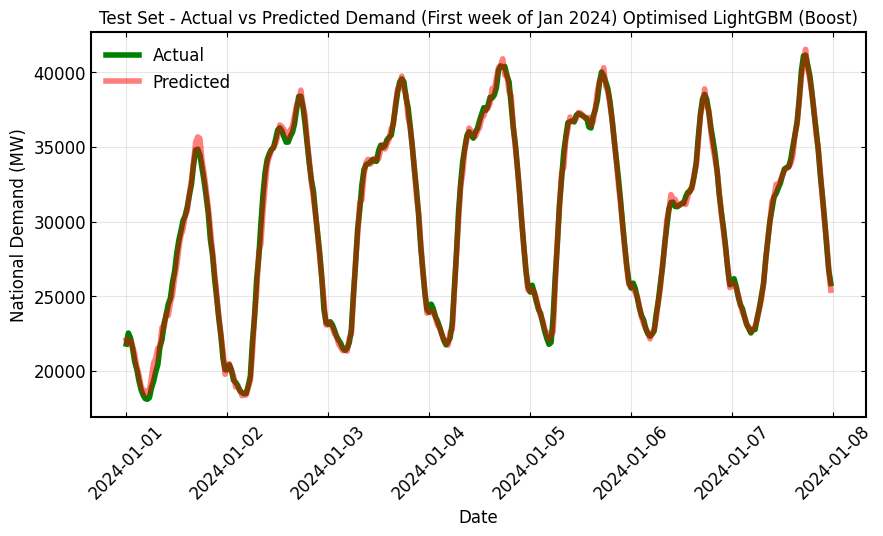

In [59]:
week_slice_opt = opt_lgbm_results.loc["2024-01-01":"2024-01-07"]

plt.figure(figsize=(10, 5))
plt.plot(week_slice_opt.index, week_slice_opt["actual"], label="Actual", linewidth=4, color="green")
plt.plot(week_slice_opt.index, week_slice_opt["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Test Set - Actual vs Predicted Demand (First week of Jan 2024) Optimised LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

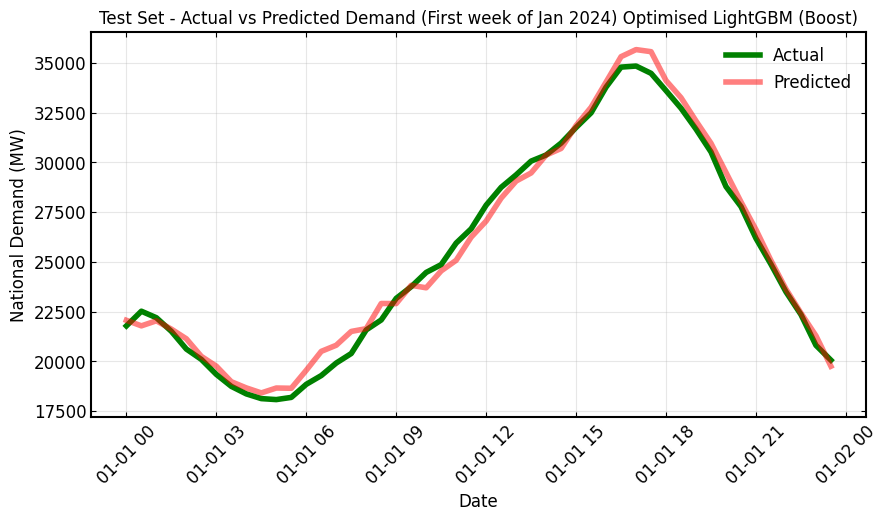

In [60]:
day_slice_opt = opt_lgbm_results.loc["2024-01-01":"2024-01-01"]

plt.figure(figsize=(10, 5))
plt.plot(day_slice_opt.index, day_slice_opt["actual"], label="Actual", linewidth=4, color="green")
plt.plot(day_slice_opt.index, day_slice_opt["predicted"], label="Predicted", linewidth=4, color="red", alpha=0.5)
figure_design()
plt.title("Test Set - Actual vs Predicted Demand (First week of Jan 2024) Optimised LightGBM (Boost)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("National Demand (MW)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=12)
plt.xticks(rotation=45)
plt.show()

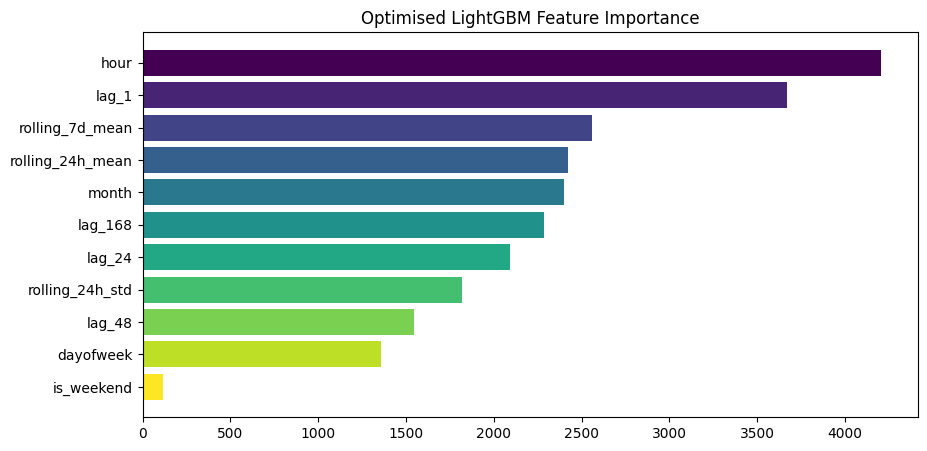

In [61]:
importance = final_lgbm.feature_importances_

feature_importance_final = pd.DataFrame({
    "feature": feature_cols,
    "importance": importance,
}).sort_values(by="importance", ascending=False)

colors = plt.cm.viridis(np.linspace(0, 1, 11))

plt.figure(figsize=(10,5))
plt.barh(feature_importance_final["feature"], feature_importance_final["importance"], color=colors)
plt.title("Optimised LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()
